In [ ]:
!pip install git+https://github.com/konstmish/opt_methods.git

  Cloning https://github.com/konstmish/opt_methods.git to /tmp/pip-req-build-sv0fb9sc
  Running command git clone -q https://github.com/konstmish/opt_methods.git /tmp/pip-req-build-sv0fb9sc
  Created wheel for opt-methods: filename=opt_methods-0.1.1-py3-none-any.whl size=53147 sha256=0ca579db4e1c6b526d03f5663e8a824b63a235d1e04594ecfca3677c4712fc98
  Stored in directory: /tmp/pip-ephem-wheel-cache-p6hbr7tq/wheels/53/68/9f/c19ccfea37130ba6bb1b3a1b4339e3e8ab4b5213f50fcb431b
Successfully built opt-methods


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import numpy.linalg as la

from optmethods.datasets import get_dataset
from optmethods.line_search import Armijo
from optmethods.loss import LogisticRegression, LogSumExp
from optmethods.first_order import Gd, RestNest
from optmethods.second_order import Cubic, Newton, RegNewton

import matplotlib
sns.set(style="whitegrid", context="talk", palette=sns.color_palette("bright"), color_codes=False)
matplotlib.rcParams['figure.figsize'] = (8, 6)

## The methods

We are going to compare the following methods:


*   GD: Gradient Descent with constant stepsize, $x^{k+1}=x^k - \frac{1}{L}\nabla f(x^k)$
*   Nesterov's acceleration with constant stepsize and restarts, $x^{k+1}=y^k - \frac{1}{L}\nabla f(y^k)$, $y^{k+1}=x^{k+1}+\beta_k(x^{k+1}-x^k)$
*   Cubic Newton of Nesterov and Polyak, $x^{k+1}=\arg\min_x\left\{\langle \nabla f(x^k), x-x^k\rangle + \frac{1}{2}\nabla^2 f(x^k)[x-x^k]^2 + \frac{H}{3}\|x-x^k\|^3 \right\}$
*   Newton-Armijo: standard Newton with Armijo line search, $x^{k+1} = x^k - \alpha_k (\nabla^2 f(x^k))^{-1}\nabla f(x^k)$
*   Our Global Newton with constant $H$, $x^{k+1} = x^k - \alpha_k (\nabla^2 f(x^k) + \lambda_k\mathbf{I})^{-1}\nabla f(x^k)$, $\lambda_k=\sqrt{H\|\nabla f(x^k)\|}$
*   AdaN: Our Global Newton with line search for estimating $H$, $x^{k+1} = x^k - \alpha_k (\nabla^2 f(x^k) + \lambda_k\mathbf{I})^{-1}\nabla f(x^k)$, $\lambda_k=\sqrt{H_k\|\nabla f(x^k)\|}$
*   AdaN+: Our Global Newton with heuristic estimation of $H$, $x^{k+1} = x^k - \alpha_k (\nabla^2 f(x^k) + \lambda_k\mathbf{I})^{-1}\nabla f(x^k)$, $\lambda_k=\sqrt{H_k\|\nabla f(x^k)\|}$

You can find the implementation of the proposed Newton method by following this link: https://github.com/konstmish/opt_methods/blob/master/optmethods/second_order/reg_newton.py#L19


In [ ]:
def setup_optimizers(loss):
    gd = Gd(loss=loss, label='GD')
    rest = RestNest(loss=loss, doubling=True, label="Nesterov's acceleration")
    gnewt = RegNewton(loss=loss, adaptive=False, use_line_search=False, 
                      label='Global Newton')
    adan = RegNewton(loss=loss, adaptive=True, use_line_search=True, 
                     label='AdaN')
    adanp = RegNewton(loss=loss, adaptive=True, use_line_search=False, 
                      label='AdaN+')
    armijo = Armijo()
    armn = Newton(loss=loss, line_search=armijo, label='Newton-Armijo')
    cub = Cubic(loss=loss, label='Cubic Newton')
    return [gd, rest, cub, armn, gnewt, adan, adanp]

markers = [',', 'o', '^', '*', 'd', 's', 'X', 'P', '.', 6, 7]

## Easy problem: Logistic Regression

In [ ]:
import sklearn.datasets
import urllib.request
w8a_url = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/w8a"
data_path = './w8a'
f = urllib.request.urlretrieve(w8a_url, data_path)
A, b = sklearn.datasets.load_svmlight_file(data_path)
A = A.toarray()

loss = LogisticRegression(A, b, l1=0, l2=0)
n, dim = A.shape
L = loss.smoothness
l2 = 1e-10 * L # make the problem ill-conditioned
loss.l2 = l2
x0 = np.ones(dim) * 0.5
it_max = 200

In [ ]:
optimizers = setup_optimizers(loss)

for opt in optimizers:
    print(f'Running optimizer: {opt.label}')
    opt.run(x0=x0, it_max=it_max)
    opt.compute_loss_of_iterates()

Running optimizer: GD
Running optimizer: Nesterov's acceleration
Running optimizer: Cubic Newton
Running optimizer: Newton-Armijo
Running optimizer: Global Newton
Running optimizer: AdaN
Running optimizer: AdaN+


Line search iteration counter is used for plots.
Line search iteration counter is used for plots.


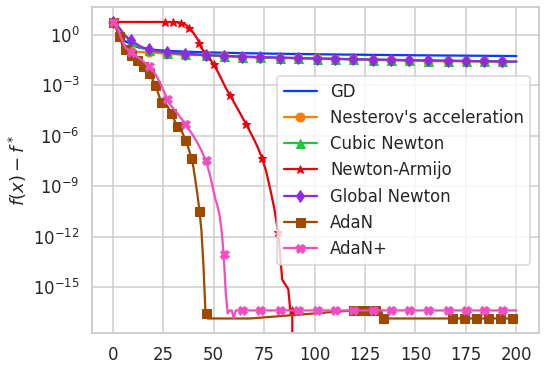

In [ ]:
for opt, marker in zip(optimizers, markers):
    opt.trace.plot_losses(marker=marker)
plt.yscale('log')
plt.legend()
plt.savefig('logistic.pdf', bbox_inches='tight')

## Hard problem: Log-Sum-Exp

Now we consider the following objective  
$\qquad f(x) = \rho\log\left(\sum_{i=1}^n \exp\left(\frac{a_i^\top x - b_i}{\rho}\right)\right) ,$  
where $a_1,\dotsc, a_n\in\mathbb{R}^d$ are some vectors and $\rho, b_1,\dotsc, b_n, \in \mathbb{R}$ are scalars.

Function $f$ is a smooth approximation of $\max\{a_1^\top x-b_1,\dotsc, a_n^\top x - b_n\}$. Its gradient, Hessian and even higher-order terms have closed-form solutions. The motivation for introducing $\rho$ is simply that it tightens the approximation, namely  
$\qquad \max\{\alpha_1,\dotsc, \alpha_n\} \le \rho\log\left(\sum_{i=1}^n\exp\left(\frac{\alpha_i}{\rho}\right)\right) \le \max\{\alpha_1,\dotsc, \alpha_n\} + \rho \log n,$  
At the same time, $f$ can sometimes be very ill-conditioned, so first-order methods might struggle when minimizing it. In particular, as $\rho$ approaches 0, $f$ becomes much harder to minimize. Below, we are going to use $\rho=0.25$, which, as we will see, too challenging for Newton with Armijo line search.

In [ ]:
seed = 0
rng = np.random.default_rng(seed)
n, dim = 500, 200
least_squares_term = False
max_smoothing = 0.25
l2 = 0
loss = LogSumExp(n=n, dim=dim, least_squares_term=least_squares_term, l2=l2, 
                 max_smoothing=max_smoothing)
x0 = rng.normal(scale=0.5, size=dim)
it_max = 1500

In [ ]:
optimizers = setup_optimizers(loss)

for opt in optimizers:
    print(f'Running optimizer: {opt.label}')
    opt.run(x0=x0, it_max=it_max)
    opt.compute_loss_of_iterates()

Running optimizer: GD
Running optimizer: Nesterov's acceleration
Running optimizer: Cubic Newton
Running optimizer: Newton-Armijo
Running optimizer: Global Newton
Running optimizer: AdaN


/usr/local/lib/python3.7/dist-packages/optmethods/line_search/reg_newton_ls.py:49: RuntimeWarning: overflow encountered in double_scalars
  reg_coef /= self.backtracking
/usr/local/lib/python3.7/dist-packages/optmethods/line_search/reg_newton_ls.py:52: RuntimeWarning: invalid value encountered in multiply
  x_new = x - np.linalg.solve(hess + identity_coef*np.eye(self.loss.dim), grad)


Running optimizer: AdaN+


Line search iteration counter is used for plots.


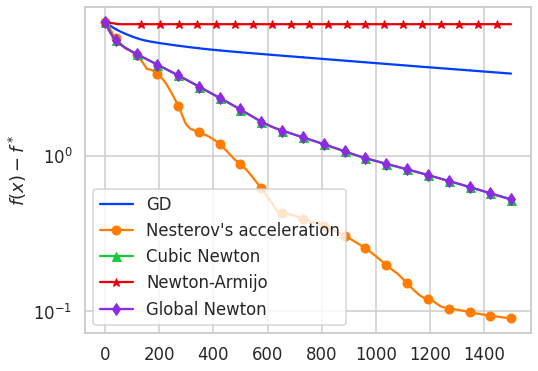

In [ ]:
for opt, marker in zip(optimizers[:-2], markers):
    opt.trace.plot_losses(marker=marker)
plt.yscale('log')
plt.legend()
plt.savefig('logsumexp_without_adan.pdf', bbox_inches='tight')

Line search iteration counter is used for plots.
Line search iteration counter is used for plots.


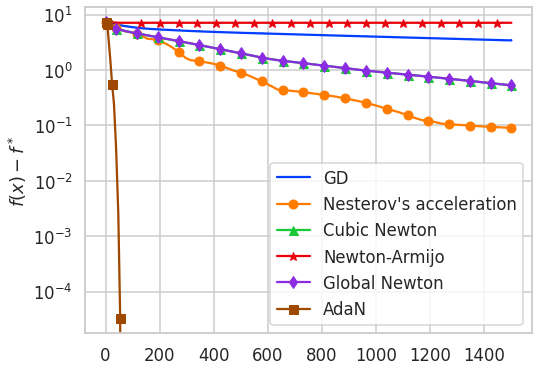

In [ ]:
for opt, marker in zip(optimizers[:-2], markers):
    opt.trace.plot_losses(marker=marker)
optimizers[-2].trace.plot_losses(marker=marker, color='black')
plt.yscale('log')
plt.legend()
plt.savefig('logsumexp.pdf', bbox_inches='tight')

## Source code links
Here we provide links to the source code of the new methods and objective functions:  
[The method](https://github.com/konstmish/opt_methods/blob/master/optmethods/second_order/reg_newton.py#L19)  
[The line search](https://github.com/konstmish/opt_methods/blob/master/optmethods/line_search/reg_newton_ls.py)  
[Logistic regression oracle](https://github.com/konstmish/opt_methods/blob/master/optmethods/loss/logistic_regression.py) that produces gradients and Hessians  
[Log-sum-exp oracle](https://github.com/konstmish/opt_methods/blob/master/optmethods/loss/log_sum_exp.py) that produces gradients and Hessians

## Conclusions
From both examples, we can see that second-order method with estimation of smoothness (Newton-Armijo, AdaN, AdaN+) work much better for both problems. However, Newton-Armijo fails to solve the second problem due to its ill-conditioning. It is also pedagogical to try to remove $\ell_2$ regularization from the first example, in which case Newton-Armijo would fail because of numpy.linalg solver complaining about the singularity of the Hesssian. To conclude, even though on many problems standard Newton method is already sufficient, there are many others where it is not, and AdaN offers a stable replacement.